# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code'))
from distcl import distcl

## Load Data

In [2]:
# Load Data
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918


# Train NN and generate constraints

In [3]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [4]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

model, preds_test, sd_test, y_test = cl_tool.train(n_hidden=1, n_nodes=10, iters=500, drop=0.05, learning_rate=1e-4)

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=4, out_features=10, bias=True)
  )
  (output_mean_layer): Linear(in_features=10, out_features=1, bias=True)
  (output_sd_layer): Linear(in_features=10, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 22870.69140625
NN fitting process finished with a validation GAUSSIANNLL loss of -0.4849381148815155 in epoch 499


In [5]:
cons = cl_tool.constraint_build(model)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7,node_8,node_9
0,0.130646,0,0,0.170602,0.268222,-0.358076,-0.404612,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.368734,0,1,-0.122953,0.134079,-0.023025,0.275721,NaN,NaN,NaN,NaN,NaN,NaN
2,0.216846,0,2,-0.051347,0.132306,-0.144275,-0.011651,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.391244,0,3,-0.506381,-0.331141,-0.284767,0.126731,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.122178,0,4,-0.001248,0.300011,-1.033687,-0.013477,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.156131,0,5,0.127046,0.415194,-0.142491,0.472969,NaN,NaN,NaN,NaN,NaN,NaN
6,0.438818,0,6,-0.121005,0.052907,0.438917,-0.358695,NaN,NaN,NaN,NaN,NaN,NaN
7,0.254901,0,7,-0.071105,-0.126583,-0.489334,0.336029,NaN,NaN,NaN,NaN,NaN,NaN
8,-0.071985,0,8,-0.203131,-0.230166,-0.343688,-0.560080,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.164022,0,9,-0.183737,0.429799,0.119745,0.124922,NaN,NaN,NaN,NaN,NaN,NaN


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


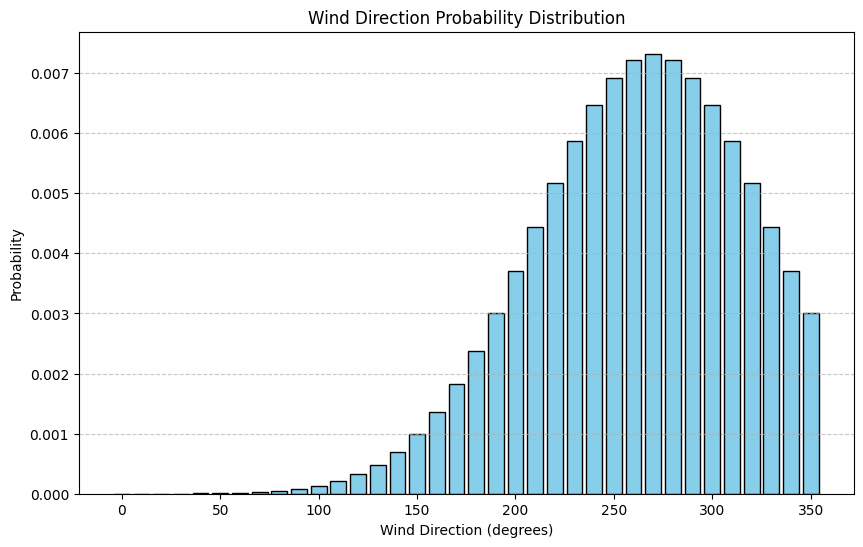

In [6]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt

# Parameters for the normal distribution
mean = 270
std_dev = 60  
x = np.arange(0, 360, 10)

# Generate the PDF and truncate 
pdf = norm.pdf(x, loc=mean, scale=std_dev)
pdf /= np.trapz(pdf, x)

# merge arrays
merged_array = np.column_stack((x, pdf))
wind_prob_dict = {int(row[0]): row[1] for row in merged_array}


# Plot the wind probability distribution
plt.figure(figsize=(10, 6))
plt.bar(wind_prob_dict.keys(), wind_prob_dict.values(), width=8, color='skyblue', edgecolor='black')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Probability')
plt.title('Wind Direction Probability Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [57]:
# Generate distribution of wind directions
from scipy.stats import norm

# Parameters
mu = 270
sd = 10
angles = np.arange(0, 360, 10)

# Circular distance function
def circular_dist(x, mu):
    d = np.abs(x - mu) % 360
    return np.minimum(d, 360 - d)

# Apply normal PDF to circular distances
distances = circular_dist(angles, mu)
densities = norm.pdf(distances, loc=0, scale=sd)
probabilities = densities / np.sum(densities)

# Create DataFrame
wind_df = pd.DataFrame({
    'wind_direction': angles,
    'probability': np.round(probabilities, 5)
})

# add variables
wind_df = wind_df[wind_df['probability'] > 0].reset_index(drop=True)

wind_df.insert(0, 'x_turb2', np.nan)
wind_df.insert(1, 'y_turb2', np.nan)

wind_df['wind_speed'] = 8


wind_df



,x_turb2,y_turb2,wind_direction,probability,wind_speed
0,NaN,NaN,230,0.00013,8
1,NaN,NaN,240,0.00443,8
2,NaN,NaN,250,0.05399,8
3,NaN,NaN,260,0.24197,8
4,NaN,NaN,270,0.39894,8
5,NaN,NaN,280,0.24197,8
6,NaN,NaN,290,0.05399,8
7,NaN,NaN,300,0.00443,8
8,NaN,NaN,310,0.00013,8


In [58]:
wind_df_contextual = wind_df.drop(columns=['probability'])
wind_df_contextual

,x_turb2,y_turb2,wind_direction,wind_speed
0,NaN,NaN,230,8
1,NaN,NaN,240,8
2,NaN,NaN,250,8
3,NaN,NaN,260,8
4,NaN,NaN,270,8
5,NaN,NaN,280,8
6,NaN,NaN,290,8
7,NaN,NaN,300,8
8,NaN,NaN,310,8


In [59]:
contextual_sample1 = pd.DataFrame({
    'x_turb2': [np.nan, np.nan, np.nan],
    'y_turb2': [np.nan, np.nan, np.nan],
    'wind_direction': [270, 315, 0],
    'wind_speed': [8, 8, 8]
})
contextual_sample1

,x_turb2,y_turb2,wind_direction,wind_speed
0,NaN,NaN,270,8
1,NaN,NaN,315,8
2,NaN,NaN,0,8


In [75]:
pi

[0.00013,
 0.00443,
 0.05399,
 0.24197,
 0.39894,
 0.24197,
 0.05399,
 0.00443,
 0.00013]

In [76]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

#contextual_sample = data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]]#.iloc[[0]]
# contextual_sample = pd.DataFrame({
#     'x_turb2': [np.nan, np.nan, np.nan],
#     'y_turb2': [np.nan, np.nan, np.nan],
#     'wind_direction': [270, 315, 0],
#     'wind_speed': [8, 8, 8]
# })
contextual_sample = wind_df.drop(columns=['probability'])
pi = list(wind_df['probability'])

n_sc = len(contextual_sample)


model.W = pyo.RangeSet(1,n_sc)
#pi = [1/n_sc for i in range(n_sc)]


model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, model.W ,within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)

model.power = pyo.Var(model.W,within=pyo.Reals) # saving power per scenario


# obj function 
def obj_expression(model):
    return sum(pi[w-1] * model.power[w] for w in model.W)
model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model, w):
    return model.power[w] == model.y['power', 0, w]
model.const_power = pyo.Constraint(model.W, rule=power)

#constraint for fixing contextual information

# Fix other contextual variables
def fix_other_vars(model, x_ind, w):
    if x_ind not in ['x_turb2', 'y_turb2']:
        return model.x[x_ind, w] == contextual_sample.loc[w - 1, x_ind]
    return pyo.Constraint.Skip
model.const_fix_other_vars = pyo.Constraint(model.var_ind, model.W, rule=fix_other_vars)


# Constraint to ensure x_turb2 and y_turb2 are the same across all scenarios
def same_across_scenarios(model, var_name):
    first_scenario = next(iter(model.W))
    return (model.x[var_name, first_scenario] == model.x[var_name, w] for w in model.W if w != first_scenario)

model.const_same_x_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'x_turb2'):
    model.const_same_x_turb2.add(constraint)

model.const_same_y_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'y_turb2'):
    model.const_same_y_turb2.add(constraint)


# Lower and upper bounds for x_turb2
def x_turb2_lb_rule(model, w):
    return 800 <= model.x['x_turb2', w]

def x_turb2_ub_rule(model, w):
    return model.x['x_turb2', w] <= 5000

model.x_turb2_lb = pyo.Constraint(model.W, rule=x_turb2_lb_rule)
model.x_turb2_ub = pyo.Constraint(model.W, rule=x_turb2_ub_rule)

# Lower and upper bounds for y_turb2
def y_turb2_lb_rule(model, w):
    return 0 <= model.x['y_turb2', w]

def y_turb2_ub_rule(model, w):
    return model.x['y_turb2', w] <= 600

model.y_turb2_lb = pyo.Constraint(model.W, rule=y_turb2_lb_rule)
model.y_turb2_ub = pyo.Constraint(model.W, rule=y_turb2_ub_rule)


# ## min distance 
# # Define constraints if any (for example, minimum distance between turbines)
# def distance_constraint(model):
#     return ((model.x_turb2 - 0)**2 + (model.y_turb2 - 0)**2) >= 400**2 
# model.distance_constraint = Constraint(rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed_modified(opt_model=model, constaints=cons, outcome='power', deterministic = True, n_scenarios=n_sc)


1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')


In [77]:
model.pprint()

1 Set Declarations
    var_ind : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'}

1 RangeSet Declarations
    W : Dimen=1, Size=9, Bounds=(1, 9)
        Key  : Finite : Members
        None :   True :   [1:9]

5 Var Declarations
    power : Size=9, Index=W
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
          3 :  None :  None :  None : False :  True :  Reals
          4 :  None :  None :  None : False :  True :  Reals
          5 :  None :  None :  None : False :  True :  Reals
          6 :  None :  None :  None : False :  True :  Reals
          7 :  None :  None :  None : False :  True :  Reals
          8 :  None :  None :  None : False :  True :  Reals
          9 :  None :  None :  None : False :  True :  Reals
  

In [78]:

# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmps_to31h4.pyomo.lp
Reading time = 0.00 seconds
x1: 376 rows, 262 columns, 1490 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 376 rows, 262 columns and 1490 nonzeros
Model fingerprint: 0xf1ad2cce
Variable types: 162 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  Objective range  [1e-04, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 5e+03]
Found heuristic solution: objective 2218.6941616
Presolve removed 335 rows and 180 columns
Presolve time: 0.00s
Presolved: 41 rows, 82 columns, 162 nonzeros
Found heuristic solution: objec

In [79]:
# print optimization results
print("\nOptimization Results:")

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")


Optimization Results:

Contextual/Decision Variables (x):
('wind_direction', 1): 230.0
('wind_direction', 2): 240.0
('wind_direction', 3): 250.0
('wind_direction', 4): 260.0
('wind_direction', 5): 270.0
('wind_direction', 6): 280.0
('wind_direction', 7): 290.0
('wind_direction', 8): 300.0
('wind_direction', 9): 310.0
('wind_speed', 1): 8.0
('wind_speed', 2): 8.0
('wind_speed', 3): 8.0
('wind_speed', 4): 8.0
('wind_speed', 5): 8.0
('wind_speed', 6): 8.0
('wind_speed', 7): 8.0
('wind_speed', 8): 8.0
('wind_speed', 9): 8.0
('x_turb2', 1): 4670.748782357859
('x_turb2', 2): 4670.748782357859
('x_turb2', 3): 4670.748782357859
('x_turb2', 4): 4670.748782357859
('x_turb2', 5): 4670.748782357859
('x_turb2', 6): 4670.748782357859
('x_turb2', 7): 4670.748782357859
('x_turb2', 8): 4670.748782357859
('x_turb2', 9): 4670.748782357859
('y_turb2', 1): 600.0
('y_turb2', 2): 600.0
('y_turb2', 3): 600.0
('y_turb2', 4): 600.0
('y_turb2', 5): 600.0
('y_turb2', 6): 600.0
('y_turb2', 7): 600.0
('y_turb2', 8

In [80]:
# Plot
plt.figure(figsize=(10, 5))
plt.bar(wind_df['direction'], wind_df['probability'], width=8, align='center', color='skyblue', edgecolor='black')
plt.title('Discrete Wrapped Normal Distribution of Wind Direction\n(mean=270°, sd=20°)')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Probability')
plt.xticks(np.arange(0, 361, 30))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

KeyError: 'direction'

<Figure size 1000x500 with 0 Axes>

In [ ]:
data_with_prob = pd.merge(data, wind_df, left_on='wind_direction', right_on='direction', how='left')

In [ ]:
data_with_prob

,x_turb2_x,y_turb2_x,wind_speed_x,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power,direction,probability,x_turb2_y,y_turb2_y,wind_speed_y
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47263,5000.0,600.0,8.0,310.0,0.06,1753.954459,1753.954459,3507.908918,310.0,0.00013,NaN,NaN,8.0
47264,5000.0,600.0,8.0,320.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
47265,5000.0,600.0,8.0,330.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN
47266,5000.0,600.0,8.0,340.0,0.06,1753.954459,1753.954459,3507.908918,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calculate the expected total power generation
data_with_prob['prob_weighted_power'] = data_with_prob['farm_power'] * data_with_prob['probability']

# Group by x_turb2 and y_turb2 to sum the expected power for each combination
expected_power_by_location = data_with_prob.groupby(['x_turb2', 'y_turb2'])['prob_weighted_power'].sum().reset_index()

# Drop rows where x_turb2 and y_turb2 are both 0
expected_power_by_location = expected_power_by_location[(expected_power_by_location['x_turb2'] != 0) | (expected_power_by_location['y_turb2'] != 0)]
expected_power_by_location

KeyError: 'x_turb2'

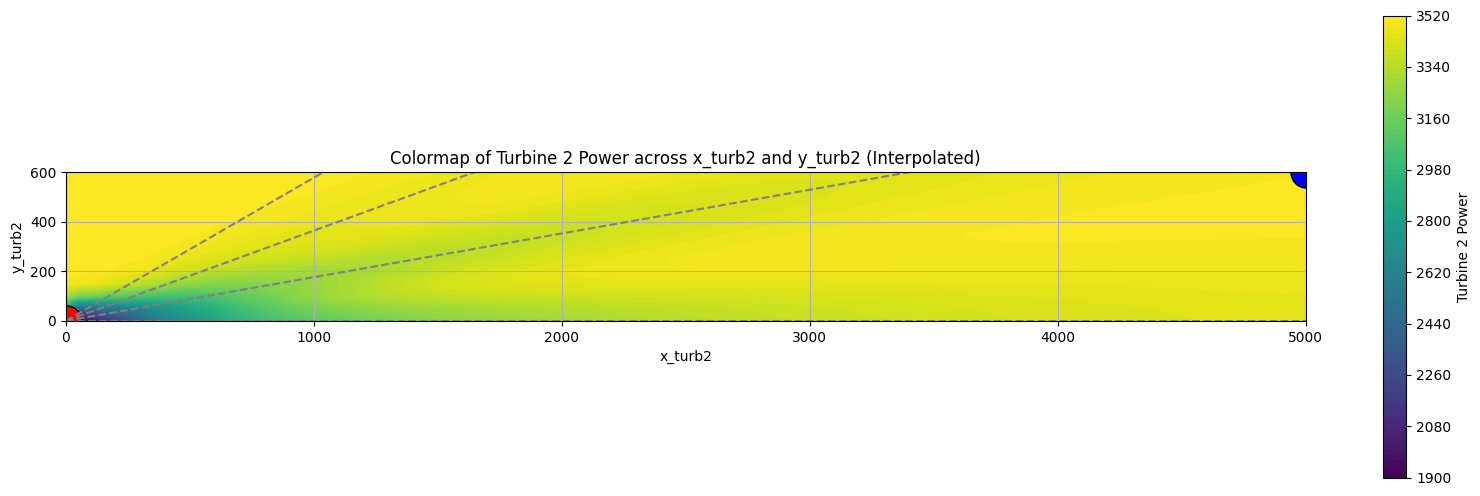

In [ ]:
# Visualize the results
from scipy.interpolate import griddata


# Colormap with interpolation
x = expected_power_by_location['x_turb2']
y = expected_power_by_location['y_turb2']
z = expected_power_by_location['prob_weighted_power']
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

plt.figure(figsize=(20, 6))
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.colorbar(label='Turbine 2 Power')

# Mark the position of wind turbine one
plt.scatter(0, 0, color='red', label='Turbine 1', s=500, edgecolor='black')

# Mark the position of the optimal location of wind turbine 2
optimal_x = pyo.value(model.x['x_turb2',1])
optimal_y = pyo.value(model.x['y_turb2',1])
plt.scatter(optimal_x, optimal_y, color='blue', label='Optimal Turbine 2', s=500, edgecolor='black')


# Add lines showing angles 10, 20, 30 degrees starting at point (0, 0)
for angle in [0, 10, 20, 30]:
    radians = np.deg2rad(angle)
    plt.plot([0, 5000 * np.cos(radians)], [0, 5000 * np.sin(radians)], linestyle='--', color='gray', label=f'{angle}°')
# cosmetics 


plt.axis('scaled')

plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())


plt.xlabel('x_turb2')
plt.ylabel('y_turb2')
plt.title('Colormap of Turbine 2 Power across x_turb2 and y_turb2 (Interpolated)')
plt.grid(True)
plt.show()


In [ ]:
# Find the maximum expected power and its corresponding x and y
max_row = expected_power_by_location.loc[expected_power_by_location['prob_weighted_power'].idxmax()]
max_power = max_row['prob_weighted_power']
max_x = max_row['x_turb2']
max_y = max_row['y_turb2']

print(f"Maximum Expected Power: {max_power}")
print(f"Corresponding x_turb2: {max_x}")
print(f"Corresponding y_turb2: {max_y}")

Maximum Expected Power: 3507.8387601799745
Corresponding x_turb2: 0.0
Corresponding y_turb2: 450.0
